In [1]:
%load_ext autoreload

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

## The basic model: amplification and persistance

In [5]:
# define some variables
t, k, K, B, u, q = sym.symbols('t, k, K, B, u, q')

# define some parameters
a, alpha, K_bar, m, R = sym.symbols('a, alpha, K_bar, m, R')

# need to specify some production function for gatherers
G = k**alpha
mpk = sym.diff(G, k, 1)

# basic model from Kiyotaki and Moore "credit-cycles" paper
K_dot = (1 / u) * ((a + q) * K - R * B) - K
B_dot = (1 / R) * q * K - B
q_dot = (R - 1) * q - R * u
u_dot = (1 / R) * mpk.subs({k: (1 / m) * (K_bar - K)}) - u

rhs = {'K': K_dot, 'B': B_dot, 'q': q_dot, 'u': u_dot}

In [449]:
bcs = {}

Kstar = K_bar - m * (alpha / (a * R))**(1 / (1 - alpha))

Bstar = (a / (R - 1)) * Kstar

# initial conditions for K and B are given
K0 = 95
bcs['lower'] = [K - K0]

# boundary conditions on q and u can be written in terms of steady state values
bcs['upper'] = [B - Bstar, q - ((R / (R - 1)) * a), u - a]

In [450]:
params = {'a': 1.01, 'm': 10.0, 'alpha': 0.33, 'R': 1.5, 'K_bar': 100}

In [643]:
# set up the model and solver
basic_model = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['K', 'B', 'q', 'u'],
                                                         independent_var='t',
                                                         rhs=rhs,
                                                         boundary_conditions=bcs,
                                                         params=params)

basic_model_solver = pycollocation.OrthogonalPolynomialSolver(basic_model)

In [703]:
def Kstar(a, m, alpha, R, K_bar):
    return K_bar - m * (alpha / (a * R))**(1 / (1 - alpha))

def Bstar(a, m, alpha, R, K_bar):
    return (a / (R - 1)) * Kstar(a, m, alpha, R, K_bar)

def qstar(a, m, alpha, R, K_bar):
    return (R / (R - 1)) * a
            
def ustar(a, m, alpha, R, K_bar):
    return a

# specify an initial guess
domain = [0, 25]
ts = np.linspace(domain[0], domain[1], 1000)
Ks = Kstar(**params) - (Kstar(**params) - K0) * np.exp(-ts)
initial_capital_poly = np.polynomial.Chebyshev.fit(ts, Ks, 33, domain)

# initial value of debt is some multiple of capital stock
B0 = 1.5 * K0
Bs = Bstar(**params) - (Bstar(**params) - B0) * np.exp(-ts) 
initial_debt_poly = np.polynomial.Chebyshev.fit(ts, Bs, 30, domain)

# starting with K0 > Kstar, must be that u0 > ustar
us = ustar(**params) - (ustar(**params) - 1.5 * ustar(**params)) * np.exp(-ts)
initial_user_cost_poly = np.polynomial.Chebyshev.fit(ts, us, 30, domain)

# starting with K0 > Kstar, must be that q0 > qstar
qs = qstar(**params) - (qstar(**params) - 1.5 * qstar(**params)) * np.exp(-ts)
initial_land_price_poly = np.polynomial.Chebyshev.fit(ts, qs, 30, domain)

initial_coefs = {'K': initial_capital_poly.coef, 'B': initial_debt_poly.coef, 
                 'u': initial_user_cost_poly.coef, 'q': initial_land_price_poly.coef}

In [704]:
basic_model_solver.solve(kind="Chebyshev",
                         coefs_dict=initial_coefs,
                         domain=domain)


In [705]:
basic_model_solver.result["success"]

True

In [706]:
basic_model_solution = pycollocation.Solution(basic_model_solver)

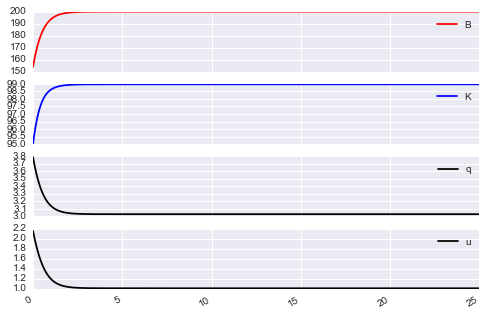

In [707]:
basic_model_solution.interpolation_knots = np.linspace(domain[0], domain[1], 1000)
basic_model_solution.solution.plot(subplots=True, style=['r', 'b'])
plt.show()

Solution is not as accurate as I would like...

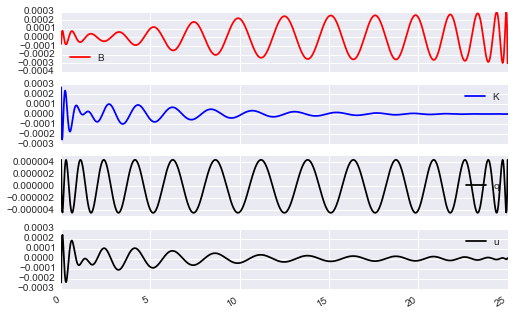

In [708]:
basic_model_solution.residuals.plot(subplots=True, style=['r', 'b'])
plt.show()

Try making the solution more accurate using a hot start...

In [698]:
initial_coefs = basic_model_solution.solver.functions

for degree in range(31, 50, 1):
    Ks = basic_model_solution.solution.K
    initial_capital_poly = np.polynomial.Chebyshev.fit(ts, Ks, degree, domain)

    Bs = basic_model_solution.solution.B 
    initial_debt_poly = np.polynomial.Chebyshev.fit(ts, Bs, degree, domain)

    us = basic_model_solution.solution.u
    initial_user_cost_poly = np.polynomial.Chebyshev.fit(ts, us, degree, domain)

    qs = basic_model_solution.solution.q
    initial_land_price_poly = np.polynomial.Chebyshev.fit(ts, qs, degree, domain)
    
    initial_coefs = {'K': initial_capital_poly.coef, 'B': initial_debt_poly.coef, 
                     'u': initial_user_cost_poly.coef, 'q': initial_land_price_poly.coef}
    
    basic_model_solver.solve(kind="Chebyshev",
                             coefs_dict=initial_coefs,
                             domain=domain)
    
    basic_model_solution = pycollocation.Solution(basic_model_solver)
    basic_model_solution.interpolation_knots = np.linspace(domain[0], domain[1], 1000)


    

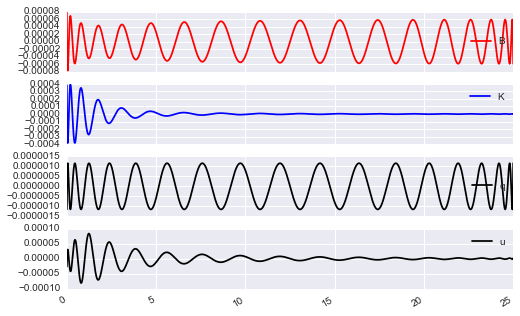

In [699]:
basic_model_solution.residuals.plot(subplots=True, style=['r', 'b'])
plt.show()

In [165]:
def credit_cycles(t, X, a, m, alpha, R, K_bar):
    out = np.array([(1 / X[3]) * ((a + X[2]) * X[0] - R * X[1]) - X[0], 
                    (1 / R) * X[2] * X[0] - X[1],
                    (R - 1) * X[2] - R * X[3],
                    (alpha / R) * ((1 / m) * (K_bar - X[0]))**(alpha - 1) - X[3]])
    return out

def jacobian(t, X, a, m, alpha, R, K_bar):
    out = np.array([[((a + X[2]) / X[3]) - 1.0, -R / X[3], X[0] / X[3], -X[3]**(-2)],
                    [(1 / R) * X[2], -1.0, (1 / R) * X[0], 0.0],
                    [0.0, 0.0, R - 1, -R],
                    [-(1 / m) * (alpha - 1) * (alpha / R) * ((1 / m) * (K_bar - X[0]))**(alpha - 2), 0.0, 0.0, -1.0]])
    return out

def Kstar(a, m, alpha, R, K_bar):
    return K_bar - m * (alpha / (a * R))**(1 / (1 - alpha))

def Bstar(a, m, alpha, R, K_bar):
    return (a / (R - 1)) * Kstar(a, m, alpha, R, K_bar)


In [166]:
initial_condition = np.array([Kstar(a, m, alpha, R, K_bar), Bstar(a, m, alpha, R, K_bar), (R / (R - 1)) * a, a])

In [167]:
initial_condition

array([K_bar - m*(alpha/(R*a))**(1/(-alpha + 1)),
       a*(K_bar - m*(alpha/(R*a))**(1/(-alpha + 1)))/(R - 1), R*a/(R - 1),
       a], dtype=object)

In [901]:
credit_cycles(0, initial_condition)

array([ -8.64019967e-12,   0.00000000e+00,   0.00000000e+00,
        -9.88098492e-14])

In [868]:
jacobian(0, initial_condition)

array([[  1.01000000e+02,  -9.61904762e-01,   9.52163239e+02,
         -9.07029478e-01],
       [  1.05000000e+02,  -1.00000000e+00,   9.89872674e+02,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e-02,
         -1.01000000e+00],
       [  2.15879931e+00,   0.00000000e+00,   0.00000000e+00,
         -1.00000000e+00]])

In [168]:
from scipy import linalg

In [169]:
from IPython.html.widgets import fixed, interact, FloatSliderWidget

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [170]:
def eigenvalues(a=1.0, m=1.0, alpha=0.33, R=1.05, K_bar=10.0):
    steady_state = np.array([Kstar(a, m, alpha, R, K_bar),
                             Bstar(a, m, alpha, R, K_bar),
                             (R / (R - 1)) * a,
                             a])
    vals, vecs = linalg.eig(jacobian(0, steady_state, a, m, alpha, R, K_bar))
    print vals

In [172]:
interact(eigenvalues, a=(0.0, 1e3, 1e0), m=(0.0, 1e2, 1e-1), R=(0.0, 1e2, 1e-2), K_bar=(0.0, 1e4, 1e1))

[  4.96886453e+04+86405.36943471j   4.96886453e+04-86405.36943471j
  -9.93761281e+04    +0.j           4.01197590e-08    +0.j        ]


In [1120]:
params = 2.0, 0.5, 0.33, 1.01, 500.0
problem = ivp.IVP(credit_cycles, jacobian)
problem.f_params = params
problem.jac_params = params

<h2> Full model </h2>